In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from functions import nth_derivative, partial
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian
import mplcyberpunk

In [2]:
plt.style.use('cyberpunk')
#mplcyberpunk.make_lines_glow()

$$\frac{dx}{dt} = \sin(\omega t)$$

$$x(t_0) = x_0$$

And the input of the network are now: $t,x_0$

The solution of the system above, is:

$$\frac{1}{\omega}(1-\cos(\omega t)) + u_0$$
And the output is $ANN$

The reparametrization fos this initial value problem is:

$$\hat{x}(t,x_0) = x_0 + (1-e^{-(t-t_0)})ANN(t,x_0)$$

In [3]:
x0_i=0.0

x0_f=5.0

ti=0.0
tf=10.0

#### Differential equation

#1 Define the fucntion that describes the differential equation F(t;x,x',...)=0

#In this case, the solutions depends on many variables, then the derivative is actually a partial derivative:
# We're going to use 
def oscilador(net,T):
    return partial(net, T, (0,)) - torch.sin(T[:,0])

#### Architecture 

In [4]:
nodos=40
ANN = nn.Sequential(nn.Linear(3, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(),nn.Linear(nodos,1))
print(ANN)

Sequential(
  (0): Linear(in_features=3, out_features=40, bias=True)
  (1): Tanh()
  (2): Linear(in_features=40, out_features=40, bias=True)
  (3): Tanh()
  (4): Linear(in_features=40, out_features=40, bias=True)
  (5): Tanh()
  (6): Linear(in_features=40, out_features=40, bias=True)
  (7): Tanh()
  (8): Linear(in_features=40, out_features=1, bias=True)
)


*** Esta función nos entrega el gradiente de la función que recibe:
$$F(x_1,x_2) \longrightarrow \nabla F(x_1,x_2)$$

In [5]:
#5 el intervalo que queremos para x
omega = torch.linspace(1,10,10)
x0 = torch.linspace(0,10,10)
t = torch.linspace(0,15,30)

T = torch.cartesian_prod(t,x0,omega)
T.requires_grad=True

In [6]:
# def nth_derivative(net, x):
#     output = net(x)

#     #grad_tensor = torch.ones(output.size(), dtype=torch.float32, requires_grad=True)
#     #gradients=torch.autograd.grad(output, x, grad_outputs=grad_tensor)[0]
#     gradients=torch.autograd.grad(output, x)[0]
#     # Calcular las derivadas parciales
#     #gradients = torch.autograd.grad(output, x)[0]
#     return gradients

In [7]:
def nth_derivative(net, x, n):
    # Initialize the gradient tensor to 1.0, as the 0th derivative is the function itself.
    ann=net(x)
    grad_tensor = torch.ones(ann.size(), dtype=torch.float32, requires_grad=True)
    for _ in range(n):
        # Compute the gradient of the network's output with respect to the input.
        ann = torch.autograd.grad(ann, x, grad_outputs=grad_tensor, create_graph=True)[0]
    return ann

In [8]:
nth_derivative(ANN,T,1)

tensor([[ 0.0097,  0.0306, -0.0033],
        [-0.0006,  0.0317,  0.0004],
        [-0.0052,  0.0289,  0.0026],
        ...,
        [-0.0018, -0.0043,  0.0063],
        [-0.0044, -0.0023,  0.0089],
        [-0.0057, -0.0004,  0.0091]], grad_fn=<MmBackward0>)

#### Reparametrization

In [9]:
def Param(T,net=ANN):
    out = net(T)
    b=1-torch.exp(ti-T[:,0])
    #return torch.reshape(T[:,1],out.size()) + b*out
    return torch.reshape(T[:,1],out.shape) + b.reshape(out.shape)*out

In [10]:
Param(T)

tensor([[ 0.0000],
        [ 0.0000],
        [ 0.0000],
        ...,
        [10.0202],
        [10.0280],
        [10.0372]], grad_fn=<AddBackward0>)

#### Cost function


In [11]:
#Now the cost function
def cost(t):
    t.requires_grad=True
    Dt = nth_derivative(Param, t,1)[:,0] #Las derivadas parciales
    osc = Dt-torch.sin(T[:,2]*T[:,0])
    return torch.linalg.norm(osc)

***$\texttt{cost}$ debería poder ser evaluada en un conjunto con la forma de $\textbf{T}$***

### Nuestras funciones deberían estar vectorizadas

In [12]:
cost(T)

tensor(37.6807, grad_fn=<LinalgVectorNormBackward0>)

In [17]:
#4 Error and optimizer
learning_rate=0.001
epocas=50000

#optimizer=torch.optim.SGD(ANN.parameters(),lr=learning_rate,momentum=0.9)
optimizer = torch.optim.Adam(ANN.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adadelta(ANN.parameters(), lr=learning_rate)

época=0.00 , loss=15.12
época=1.00 , loss=63.51
época=2.00 , loss=40.86
época=3.00 , loss=23.28
época=4.00 , loss=35.63
época=5.00 , loss=36.12
época=6.00 , loss=30.04
época=7.00 , loss=22.58
época=8.00 , loss=23.37
época=9.00 , loss=27.59
época=10.00 , loss=26.98
época=11.00 , loss=21.58
época=12.00 , loss=18.51
época=13.00 , loss=22.04
época=14.00 , loss=22.95
época=15.00 , loss=20.47
época=16.00 , loss=18.07
época=17.00 , loss=18.56
época=18.00 , loss=20.01
época=19.00 , loss=19.03
época=20.00 , loss=16.99
época=21.00 , loss=17.33
época=22.00 , loss=18.09
época=23.00 , loss=17.36
época=24.00 , loss=16.57
época=25.00 , loss=16.95
época=26.00 , loss=16.92
época=27.00 , loss=16.30
época=28.00 , loss=16.27
época=29.00 , loss=16.35
época=30.00 , loss=15.78
época=31.00 , loss=15.81
época=32.00 , loss=16.23
época=33.00 , loss=15.86
época=34.00 , loss=15.29
época=35.00 , loss=15.57
época=36.00 , loss=15.85
época=37.00 , loss=15.27
época=38.00 , loss=15.23
época=39.00 , loss=15.45
época=40.0

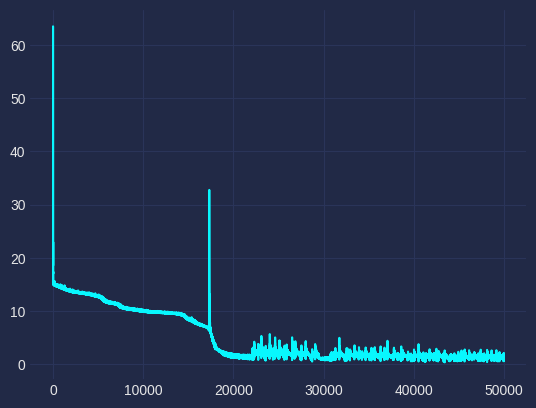

In [18]:
#loop de entrenamiendo 
errores=[]
for i in range(epocas):
    l=cost(T) #coste
    l.backward() #gradiente
    optimizer.step() #se actualizan los parámetros
    optimizer.zero_grad() #vacíamos el gradiente
    #print('época=%.2f , loss=%.2f'%(i,l))
    errores.append(float(l))
    print('época=%.2f , loss=%.2f'%(i,l))



plt.plot(range(epocas),errores)

In [19]:
x = torch.linspace(0,15,50)
x=x.reshape(50,1)
Om = 5
u = torch.linspace(0,15,50)
v = 4.0*torch.ones(u.size())
w = Om*torch.ones(u.size())
X = torch.cartesian_prod(u,v,w)


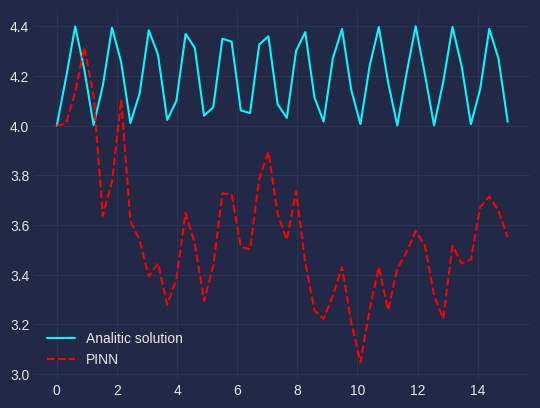

In [20]:

#plt.plot(x,x**2,'ro')-torch.cos(x)
plt.plot(x,4.0+1/Om * (1-torch.cos(Om*x)),label='Analitic solution')
plt.plot(X[:,0],Param(X,net=ANN).detach().numpy(),'--r', label='PINN')
plt.legend()
#mplcyberpunk.make_lines_glow()